In [112]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [113]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import networkx as nx
import scipy
import json
import sys
path = ''
sys.path.append(path)
import utils
import settings
import pickle
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [114]:
def save(nom,model):
  # Enregistrez le modele (ML/scaler/autre) dans un fichier
  with open(nom+'.pkl', 'wb') as f:
      pickle.dump(model, f)

In [115]:
def f_open(chemin):
  with open(chemin, 'rb') as f:
    modele = pickle.load(f)
  return modele

In [116]:
path = path
train_a, train_b, train_c, X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c = utils.read_files(diff_path=path)
test = pd.read_csv(path+"test.csv")
sample_submission = pd.read_csv(path+"sample_submission.csv")

# B and C clean up

In [117]:
def filter_dates_when_constants(df, date_c = 'time', y = 'pv_measurement', delta = { 'days': 3 }):
    df = df.copy()
    mask_y_change = df[y] != df[y].shift(1)

    start_date = None
    end_date = None

    constant_periods = []

    for index, row in df.iterrows():
        if not mask_y_change[index]:
            if start_date is None:
                start_date = row[date_c]
            end_date = row[date_c]
        else:
            if start_date is not None and (end_date - start_date) >= pd.Timedelta(**delta):
                constant_periods.append((start_date, end_date))
            start_date = None
            end_date = None

    if start_date is not None and (end_date - start_date) >= pd.Timedelta(**delta):
        constant_periods.append((start_date, end_date))
    return constant_periods

In [118]:
def delete_date_range_from_df(df, dates, date_c = 'time'):
    df = df.copy()
    c = 0
    for start_date, end_date in dates:
        mask = (df[date_c] >= start_date) & (df[date_c] < end_date)
        df = df[~mask]
    df.reset_index(drop=True, inplace=True)
    return df

In [119]:
delta = { 'hours': 12 * 5}
train_a = delete_date_range_from_df(train_a, filter_dates_when_constants(train_a, delta=delta))
train_b = delete_date_range_from_df(train_b, filter_dates_when_constants(train_b, delta=delta))
train_c = delete_date_range_from_df(train_c, filter_dates_when_constants(train_c, delta=delta))

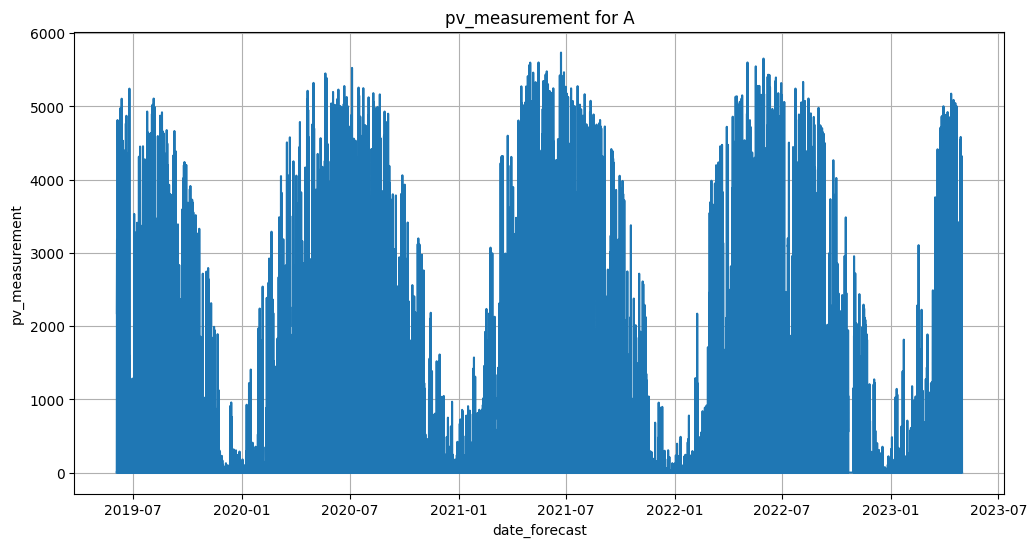

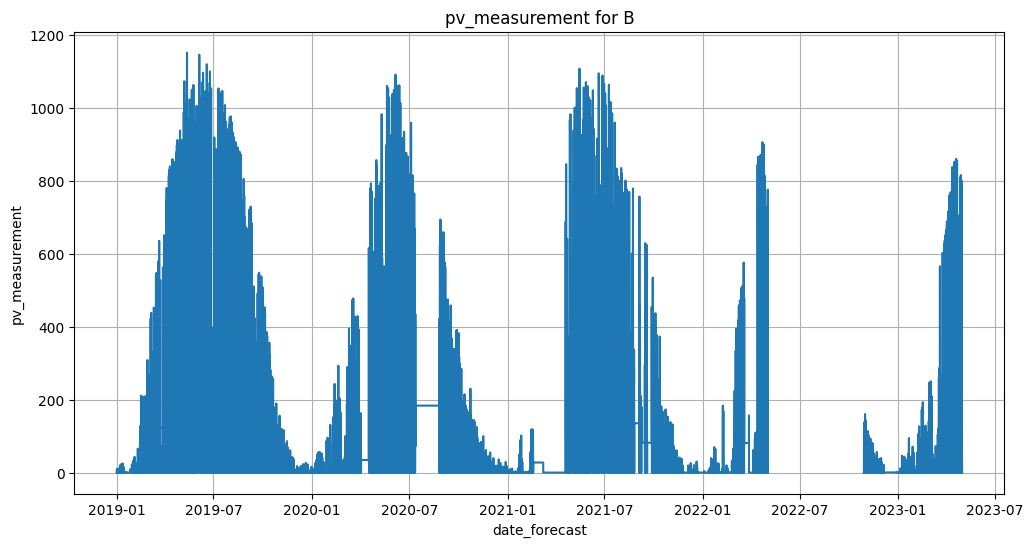

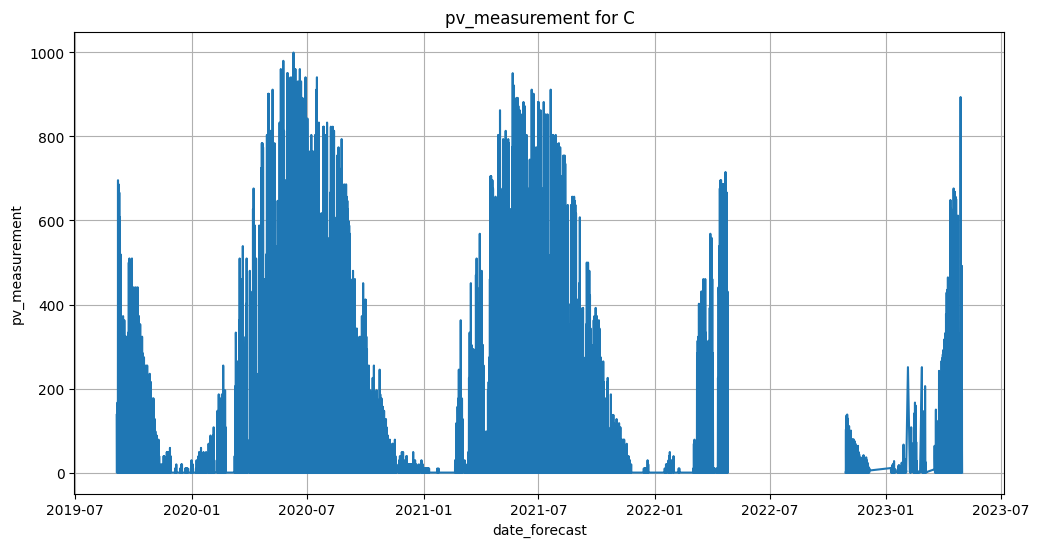

In [120]:
plt.figure(figsize=(12, 6)) 
plt.plot(train_a['time'], train_a['pv_measurement'])
plt.title('pv_measurement for A')
plt.xlabel('date_forecast') 
plt.ylabel('pv_measurement')
plt.grid(True)
plt.show()    

plt.figure(figsize=(12, 6)) 
plt.plot(train_b['time'], train_b['pv_measurement'])
plt.title('pv_measurement for B')
plt.xlabel('date_forecast') 
plt.ylabel('pv_measurement')
plt.grid(True)
plt.show()    

plt.figure(figsize=(12, 6)) 
plt.plot(train_c['time'], train_c['pv_measurement'])
plt.title('pv_measurement for C')
plt.xlabel('date_forecast') 
plt.ylabel('pv_measurement')
plt.grid(True)
plt.show()   

# Réorganisation des df :

In [121]:
# observed + estimated
X_total_a = pd.concat([X_train_observed_a,X_train_estimated_a])
X_total_b = pd.concat([X_train_observed_b,X_train_estimated_b])
X_total_c = pd.concat([X_train_observed_c,X_train_estimated_c])

Attention, il faut penser à revoir les valeurs météo et pv de estimated !!!

# Changement nom time dans les train

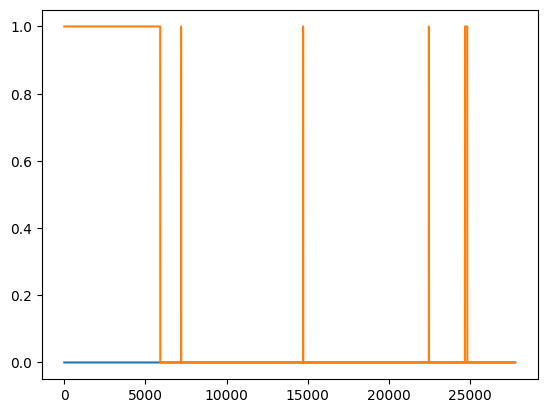

In [122]:
plt.plot(train_c.isna())

In [123]:
train_a.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
train_b.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
train_c.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
test.rename(columns={'time': 'date_forecast'}, inplace=True)

train_a.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides
train_b.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides
train_c.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides

# Correspondance X et y :

Ici nous avons plusieurs choix :    
- matcher directement sur dateforcast
- matcher sur dateforcast et résumer nos variables météo en moyenne et écart type
- matcher sur un autre créneau (peut être fais sur des variables spécifique !)

Dans un premier temps on fera directement sur dateforcast

In [124]:
X_total_a_y = pd.merge(X_total_a, train_a, on='date_forecast', how='inner')
X_total_b_y = pd.merge(X_total_b, train_b, on='date_forecast', how='inner')
X_total_c_y = pd.merge(X_total_c, train_c, on='date_forecast', how='inner')

# Analyse des Nan

In [125]:
X_train_observed_a['snow_density:kgm3'].isna().sum()/len(X_train_observed_a)

0.9770453951748139

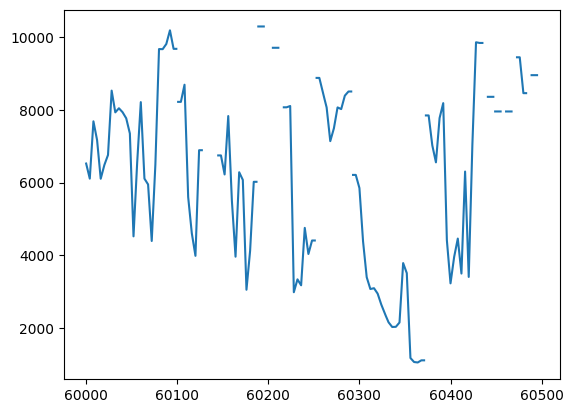

In [126]:
plt.plot(X_train_observed_a['ceiling_height_agl:m'][60000:60500])
#.plot(X_train_observed_a_nan['ceiling_height_agl:m'][60000:60500],ls="--")
#plt.plot(X_train_observed_a['cloud_base_agl:m'][60000:62000].isna())

In [127]:
X_train_observed_a.isna().sum(axis=0)/len(X_train_observed_a)

date_forecast                     0.000000
absolute_humidity_2m:gm3          0.000000
air_density_2m:kgm3               0.000000
ceiling_height_agl:m              0.187471
clear_sky_energy_1h:J             0.000000
clear_sky_rad:W                   0.000000
cloud_base_agl:m                  0.067971
dew_or_rime:idx                   0.000000
dew_point_2m:K                    0.000000
diffuse_rad:W                     0.000000
diffuse_rad_1h:J                  0.000000
direct_rad:W                      0.000000
direct_rad_1h:J                   0.000000
effective_cloud_cover:p           0.000000
elevation:m                       0.000000
fresh_snow_12h:cm                 0.000000
fresh_snow_1h:cm                  0.000000
fresh_snow_24h:cm                 0.000000
fresh_snow_3h:cm                  0.000000
fresh_snow_6h:cm                  0.000000
is_day:idx                        0.000000
is_in_shadow:idx                  0.000000
msl_pressure:hPa                  0.000000
precip_5min

**Conclusion** de l'analyse :    
- Il y a 3 variables avec des Nan
- Snow density est vide à 98% on la supprime
- les deux autres sont vide à 7 et 19% et ce sont des points manquant (problème dans la prise de mesure probablement)
- on décide donc de les compléter par prolongement (moyenne des points environnant)

In [128]:
def gestion_nan(df):
  df_copy = df.copy()
  #delete of the snow density column
  df_copy = df_copy.drop('snow_density:kgm3',axis=1)
  # Approximation of the other two columns
  df_copy['ceiling_height_agl:m'] = df_copy['ceiling_height_agl:m'].interpolate(method='linear', limit_direction='both')
  df_copy['cloud_base_agl:m'] = df_copy['cloud_base_agl:m'].interpolate(method='linear', limit_direction='both')
  return df_copy

In [129]:
X_train_observed_a_nan = gestion_nan(X_train_observed_a)

In [130]:
X_train_observed_a_nan.isna().sum(axis=0)/len(X_train_observed_a_nan)

date_forecast                     0.0
absolute_humidity_2m:gm3          0.0
air_density_2m:kgm3               0.0
ceiling_height_agl:m              0.0
clear_sky_energy_1h:J             0.0
clear_sky_rad:W                   0.0
cloud_base_agl:m                  0.0
dew_or_rime:idx                   0.0
dew_point_2m:K                    0.0
diffuse_rad:W                     0.0
diffuse_rad_1h:J                  0.0
direct_rad:W                      0.0
direct_rad_1h:J                   0.0
effective_cloud_cover:p           0.0
elevation:m                       0.0
fresh_snow_12h:cm                 0.0
fresh_snow_1h:cm                  0.0
fresh_snow_24h:cm                 0.0
fresh_snow_3h:cm                  0.0
fresh_snow_6h:cm                  0.0
is_day:idx                        0.0
is_in_shadow:idx                  0.0
msl_pressure:hPa                  0.0
precip_5min:mm                    0.0
precip_type_5min:idx              0.0
pressure_100m:hPa                 0.0
pressure_50m

# Traitement des df + séparation train/test

## Séparation train/test

A la fin on va projeter à partir de donnée météo estimer sur un periode non rencontré.

On va donc séparer notre train/test sur les même conditions, à savoir que le test sera issue de estimated. Il ne reste qu'à fixer la date à partir de laquelle on fait la séparation.

L'objectif est aussi d'avoir de l'estimated dans l'entrainement pour prendre en compte la différence entre observed et estimated qui devra être régler plus tard.

In [131]:
print(len(X_train_observed_a))
print(len(X_train_estimated_a))
print(len(X_train_estimated_a)/(len(X_train_estimated_a)+len(X_train_observed_a)))

118669
17576
0.12900289918896107


In [132]:
X_total_a_y_nan = gestion_nan(X_total_a_y)
X_total_b_y_nan = gestion_nan(X_total_b_y)
X_total_c_y_nan = gestion_nan(X_total_c_y)

In [133]:
split_date_a = X_train_estimated_a['date_forecast'].quantile(0.25)
split_date_b = X_train_estimated_b['date_forecast'].quantile(0.25)
split_date_c = X_train_estimated_c['date_forecast'].quantile(0.25)

In [134]:
split_date_a = pd.to_datetime("2021-04-15")
split_date2_a = pd.to_datetime("2021-08-15")

split_date_b = pd.to_datetime("2019-04-15")
split_date2_b = pd.to_datetime("2019-08-15")

split_date_c = pd.to_datetime("2021-04-15")
split_date2_c = pd.to_datetime("2021-08-15")

In [135]:
# on coupe nos dataframe à une certaine date

# pv_train_a = X_total_a_y_nan[X_total_a_y_nan['date_forecast'] <= split_date_a].copy()
# pv_test_a = X_total_a_y_nan[X_total_a_y_nan['date_forecast'] > split_date_a].copy()

# pv_train_b = X_total_b_y_nan[X_total_b_y_nan['date_forecast'] <= split_date_b].copy()
# pv_test_b = X_total_b_y_nan[X_total_b_y_nan['date_forecast'] > split_date_b].copy()

# pv_train_c = X_total_c_y_nan[X_total_c_y_nan['date_forecast'] <= split_date_c].copy()
# pv_test_c = X_total_c_y_nan[X_total_c_y_nan['date_forecast'] > split_date_c].copy()

pv_train_a = X_total_a_y_nan[(X_total_a_y_nan['date_forecast'] <= split_date_a) | (X_total_a_y_nan['date_forecast'] > split_date2_a)].copy()
pv_test_a = X_total_a_y_nan[(X_total_a_y_nan['date_forecast'] > split_date_a) & (X_total_a_y_nan['date_forecast'] <= split_date2_a)].copy()

pv_train_b = X_total_b_y_nan[(X_total_b_y_nan['date_forecast'] <= split_date_b) | (X_total_b_y_nan['date_forecast'] > split_date2_b)].copy()
pv_test_b = X_total_b_y_nan[(X_total_b_y_nan['date_forecast'] > split_date_b) & (X_total_b_y_nan['date_forecast'] <= split_date2_b)].copy()

pv_train_c = X_total_c_y_nan[(X_total_c_y_nan['date_forecast'] <= split_date_c) | (X_total_c_y_nan['date_forecast'] > split_date2_c)].copy()
pv_test_c = X_total_c_y_nan[(X_total_c_y_nan['date_forecast'] > split_date_c) & (X_total_c_y_nan['date_forecast'] <= split_date2_c)].copy()


print("train_a :",pv_train_a.shape)
print("test_a :",pv_test_a.shape)
print("Rapport test/total :", round(pv_test_a.shape[0]/(pv_test_a.shape[0]+pv_train_a.shape[0]),3)*100)
print("train_b :",pv_train_b.shape)
print("test_b :",pv_test_b.shape)
print("Rapport test/total :", round(pv_test_b.shape[0]/(pv_test_b.shape[0]+pv_train_b.shape[0]),3)*100)
print("train_c :",pv_train_c.shape)
print("test_c :",pv_test_c.shape)
print("Rapport test/total :", round(pv_test_c.shape[0]/(pv_test_c.shape[0]+pv_train_c.shape[0]),3)*100)

train_a : (31117, 47)
test_a : (2928, 47)
Rapport test/total : 8.6
train_b : (24311, 47)
test_b : (2852, 47)
Rapport test/total : 10.5
train_c : (18774, 47)
test_c : (2928, 47)
Rapport test/total : 13.5


## Changement type de la date_forecast

In [136]:
# on change le type de date_forecast
pv_train_a['date_forecast'] = pd.to_datetime(pv_train_a['date_forecast'])
pv_test_a['date_forecast'] = pd.to_datetime(pv_test_a['date_forecast'])

pv_train_b['date_forecast'] = pd.to_datetime(pv_train_b['date_forecast'])
pv_test_b['date_forecast'] = pd.to_datetime(pv_test_b['date_forecast'])

pv_train_c['date_forecast'] = pd.to_datetime(pv_train_c['date_forecast'])
pv_test_c['date_forecast'] = pd.to_datetime(pv_test_c['date_forecast'])

## Filtrage des variables

In [137]:
pv_train_a.columns

Index(['date_forecast', 'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_depth:cm', 'snow_drift:idx', 'snow_melt_10min:mm',
       'snow_water:kgm2', 'sun_azimuth:d', 'sun_elevation:d',
       'super_cooled_liquid_water:kgm2', 't_1000hPa:K', 'total_cloud_cover:p',
       'visibility:m', 'wind_speed_10m:ms', 'wind_speed_u_10m:ms',
       'wind_speed_v_10m:ms

In [138]:
#function to apply XGBoost model
def create_features(df, label):

    # V2
    df['hour'] = df["date_forecast"].dt.hour
    df['dayofweek'] = df["date_forecast"].dt.dayofweek
    df['quarter'] = df["date_forecast"].dt.quarter
    df['month'] = df["date_forecast"].dt.month
    df['year'] = df["date_forecast"].dt.year
    df['dayofyear'] = df["date_forecast"].dt.dayofyear
    df['dayofmonth'] = df["date_forecast"].dt.day
    # fin V2
    df = df.drop(["date_calc","date_forecast"],axis=1) # date de calcul des estimated inutil pour l'instant
    if label:
        y = df[label]
        df = df.drop(label,axis=1)
        return df, y
    return df

In [139]:
X_train_a, y_train_a = create_features(pv_train_a, label='pv_measurement')
X_test_a, y_test_a = create_features(pv_test_a, label='pv_measurement')

X_train_b, y_train_b = create_features(pv_train_b, label='pv_measurement')
X_test_b, y_test_b = create_features(pv_test_b, label='pv_measurement')

X_train_c, y_train_c = create_features(pv_train_c, label='pv_measurement')
X_test_c, y_test_c = create_features(pv_test_c, label='pv_measurement')

## Conversion du type de la date

In [140]:
# X_train_a[('date_forecast')] = X_train_a[('date_forecast')].values.astype("float64")
# X_train_b[('date_forecast')] = X_train_b[('date_forecast')].values.astype("float64")
# X_train_c[('date_forecast')] = X_train_c[('date_forecast')].values.astype("float64")
# X_test_a[('date_forecast')] = X_test_a[('date_forecast')].values.astype("float64")
# X_test_b[('date_forecast')] = X_test_b[('date_forecast')].values.astype("float64")
# X_test_c[('date_forecast')] = X_test_c[('date_forecast')].values.astype("float64")

## Normalisation

In [141]:
from sklearn.preprocessing import Normalizer, RobustScaler

def sklearn_z_score_normalize_dataframe(df,return_scaler=False,scaler=None):
    """
    Normalizes a DataFrame using z-score normalization (mean and standard deviation) from Scikit-Learn.

    Parameters:
    df (pd.DataFrame): The DataFrame to be normalized.

    Returns:
    pd.DataFrame: The z-score normalized DataFrame.
    """
    if scaler == None :
      # Create a StandardScaler instance
      # scaler = Normalizer()
      # scaler = RobustScaler()
      scaler = StandardScaler()

      # Fit the scaler on the DataFrame and transform the data
      normalized_data = scaler.fit_transform(df)

    else : normalized_data = scaler.transform(df)

    # Create a new DataFrame with the scaled data
    normalized_df = pd.DataFrame(normalized_data, columns=df.columns)

    # retourner le scaler
    if return_scaler :
      return normalized_df,scaler
    return normalized_df

In [142]:
X_train_a_norm,scaler_a = sklearn_z_score_normalize_dataframe(X_train_a,return_scaler=True)
X_train_b_norm,scaler_b = sklearn_z_score_normalize_dataframe(X_train_b,return_scaler=True)
X_train_c_norm,scaler_c = sklearn_z_score_normalize_dataframe(X_train_c,return_scaler=True)

In [143]:
X_test_a_norm = sklearn_z_score_normalize_dataframe(X_test_a,return_scaler=False,scaler=scaler_a)
X_test_b_norm = sklearn_z_score_normalize_dataframe(X_test_b,return_scaler=False,scaler=scaler_b)
X_test_c_norm = sklearn_z_score_normalize_dataframe(X_test_c,return_scaler=False,scaler=scaler_c)

## Preprocessing globale

faire un code qui reprend toute les étapes ci dessus pour éviter de faire plein de lignes qui  se répêtes !!!

# Partie XBGoost de base (Nahel)

In [144]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error

In [145]:
# Créez un modèle XGBoost
reg_a = xgb.XGBRegressor(n_estimators=10000)

# Entraînez le modèle et suivez l'évolution des erreurs
reg_a.fit(X_train_a_norm, y_train_a,
          eval_set=[(X_train_a_norm, y_train_a), (X_test_a_norm, y_test_a)],
          early_stopping_rounds=50,
          verbose=True)

reg_b = xgb.XGBRegressor(n_estimators=10000)
reg_b.fit(X_train_b_norm, y_train_b,
          eval_set=[(X_train_b_norm, y_train_b), (X_test_b_norm, y_test_b)],
          early_stopping_rounds=50,
          verbose=True)

reg_c = xgb.XGBRegressor(n_estimators=10000)
reg_c.fit(X_train_c_norm, y_train_c,
          eval_set=[(X_train_c_norm, y_train_c), (X_test_c_norm, y_test_c)],
          early_stopping_rounds=50,
          verbose=True)

[0]	validation_0-rmse:830.30528	validation_1-rmse:1363.66124
[1]	validation_0-rmse:660.01707	validation_1-rmse:1084.00149
[2]	validation_0-rmse:552.60039	validation_1-rmse:906.38298
[3]	validation_0-rmse:484.84730	validation_1-rmse:802.95421
[4]	validation_0-rmse:444.87535	validation_1-rmse:742.82936
[5]	validation_0-rmse:418.41503	validation_1-rmse:708.16173
[6]	validation_0-rmse:402.49218	validation_1-rmse:684.89625
[7]	validation_0-rmse:392.36067	validation_1-rmse:668.87092
[8]	validation_0-rmse:382.57773	validation_1-rmse:661.76914
[9]	validation_0-rmse:375.07372	validation_1-rmse:655.43456
[10]	validation_0-rmse:368.57703	validation_1-rmse:649.37664
[11]	validation_0-rmse:361.85859	validation_1-rmse:648.43534
[12]	validation_0-rmse:357.12096	validation_1-rmse:647.07399


[13]	validation_0-rmse:353.49057	validation_1-rmse:649.37388
[14]	validation_0-rmse:348.76656	validation_1-rmse:647.28816
[15]	validation_0-rmse:346.20967	validation_1-rmse:646.29154
[16]	validation_0-rmse:344.09761	validation_1-rmse:646.62597
[17]	validation_0-rmse:342.07108	validation_1-rmse:645.83258
[18]	validation_0-rmse:337.93264	validation_1-rmse:647.26102
[19]	validation_0-rmse:332.53430	validation_1-rmse:647.39169
[20]	validation_0-rmse:329.06847	validation_1-rmse:649.01567
[21]	validation_0-rmse:326.13481	validation_1-rmse:649.21941
[22]	validation_0-rmse:323.86043	validation_1-rmse:648.22439
[23]	validation_0-rmse:319.92490	validation_1-rmse:648.08274
[24]	validation_0-rmse:317.04807	validation_1-rmse:647.92190
[25]	validation_0-rmse:315.43620	validation_1-rmse:648.62359
[26]	validation_0-rmse:314.00930	validation_1-rmse:650.74797
[27]	validation_0-rmse:310.61764	validation_1-rmse:652.11668
[28]	validation_0-rmse:307.89590	validation_1-rmse:651.77751
[29]	validation_0-rmse:3

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[44]	validation_0-rmse:273.89540	validation_1-rmse:660.75671
[45]	validation_0-rmse:272.83760	validation_1-rmse:660.84335
[46]	validation_0-rmse:270.74578	validation_1-rmse:661.38239
[47]	validation_0-rmse:269.89307	validation_1-rmse:661.52643
[48]	validation_0-rmse:268.46150	validation_1-rmse:661.21805
[49]	validation_0-rmse:267.73419	validation_1-rmse:661.48088
[50]	validation_0-rmse:266.26524	validation_1-rmse:661.28702
[51]	validation_0-rmse:264.72433	validation_1-rmse:661.86708
[52]	validation_0-rmse:263.28686	validation_1-rmse:661.85566
[53]	validation_0-rmse:262.32185	validation_1-rmse:662.55934
[54]	validation_0-rmse:260.92864	validation_1-rmse:662.92109
[55]	validation_0-rmse:258.96511	validation_1-rmse:662.64060
[56]	validation_0-rmse:256.26952	validation_1-rmse:663.22176
[57]	validation_0-rmse:254.53419	validation_1-rmse:664.03210
[58]	validation_0-rmse:253.99210	validation_1-rmse:663.76924
[59]	validation_0-rmse:253.10276	validation_1-rmse:663.73809
[60]	validation_0-rmse:2

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:29.34698	validation_1-rmse:136.60689
[0]	validation_0-rmse:116.35188	validation_1-rmse:211.82810
[1]	validation_0-rmse:89.98827	validation_1-rmse:162.46316
[2]	validation_0-rmse:72.51693	validation_1-rmse:131.77551
[3]	validation_0-rmse:61.54011	validation_1-rmse:114.42188
[4]	validation_0-rmse:54.49088	validation_1-rmse:105.02237
[5]	validation_0-rmse:49.62077	validation_1-rmse:98.92197
[6]	validation_0-rmse:46.44756	validation_1-rmse:96.58688
[7]	validation_0-rmse:44.72175	validation_1-rmse:95.14450
[8]	validation_0-rmse:43.03511	validation_1-rmse:94.94028
[9]	validation_0-rmse:41.65445	validation_1-rmse:95.14259
[10]	validation_0-rmse:40.51242	validation_1-rmse:95.17664
[11]	validation_0-rmse:39.62133	validation_1-rmse:95.85340
[12]	validation_0-rmse:38.93608	validation_1-rmse:95.72214
[13]	validation_0-rmse:38.59293	validation_1-rmse:95.97852
[14]	validation_0-rmse:37.95330	validation_1-rmse:96.55418
[15]	validation_0-rmse:37.13434	validation_1-rmse:96.17483


/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

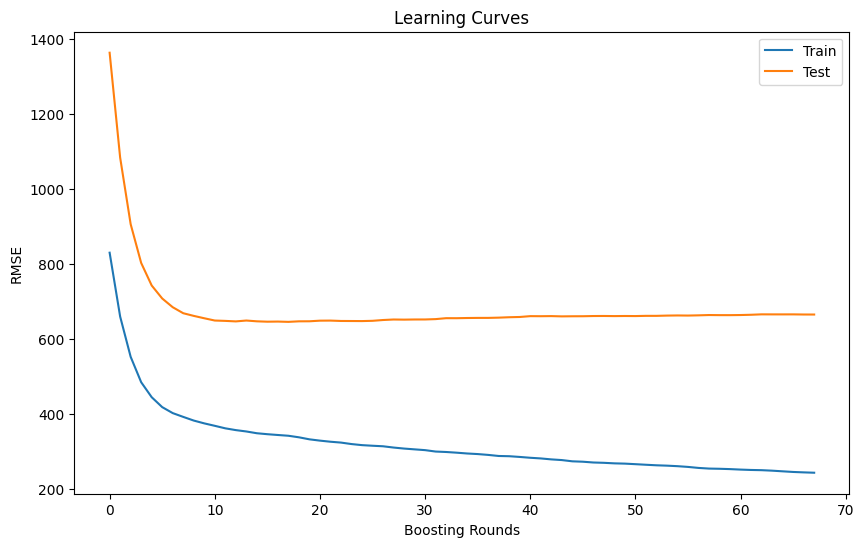

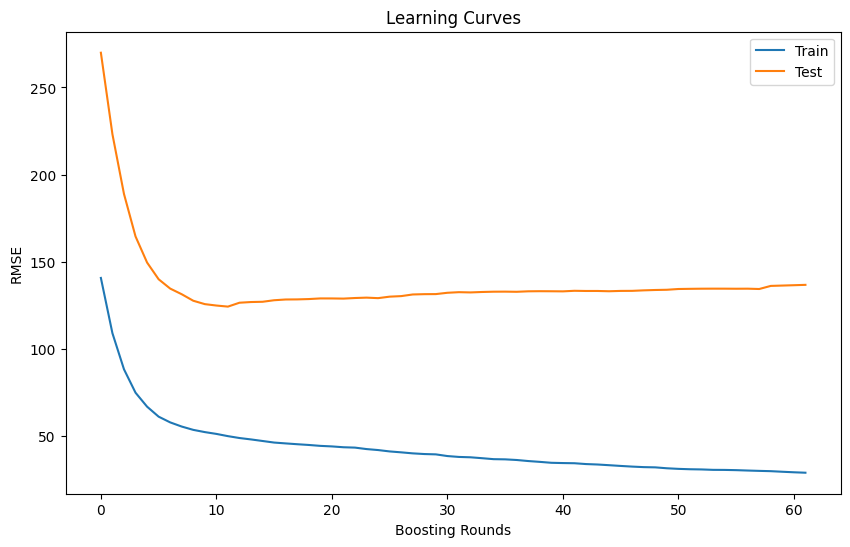

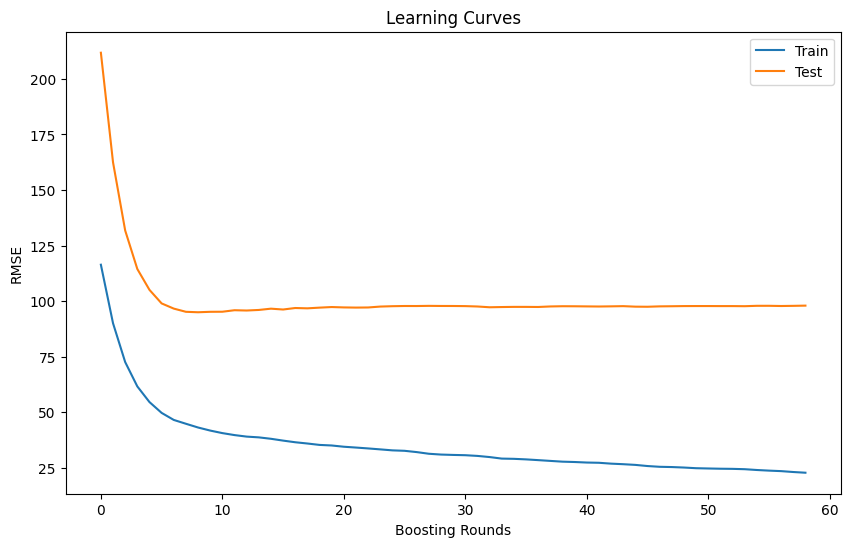

In [146]:
# Créez des listes vides pour stocker les erreurs d'entraînement et de test
train_errors = []
test_errors = []

# Accédez aux erreurs d'entraînement et de test après chaque itération
results = reg_a.evals_result()
train_errors = results['validation_0']['rmse']
test_errors = results['validation_1']['rmse']

# Tracez les courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train')
plt.plot(test_errors, label='Test')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.legend()
plt.title('Learning Curves')
plt.show()

min_error_a = min(test_errors)
# Créez des listes vides pour stocker les erreurs d'entraînement et de test
train_errors = []
test_errors = []

# Accédez aux erreurs d'entraînement et de test après chaque itération
results = reg_b.evals_result()
train_errors = results['validation_0']['rmse']
test_errors = results['validation_1']['rmse']

# Tracez les courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train')
plt.plot(test_errors, label='Test')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.legend()
plt.title('Learning Curves')
plt.show()

min_error_b = min(test_errors)
# Créez des listes vides pour stocker les erreurs d'entraînement et de test
train_errors = []
test_errors = []

# Accédez aux erreurs d'entraînement et de test après chaque itération
results = reg_c.evals_result()
train_errors = results['validation_0']['rmse']
test_errors = results['validation_1']['rmse']

min_error_c = min(test_errors)
# Tracez les courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train')
plt.plot(test_errors, label='Test')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.legend()
plt.title('Learning Curves')
plt.show()

In [147]:
min_error_a, min_error_b, min_error_c

(645.8325820461115, 124.34176733018363, 94.94027554413424)

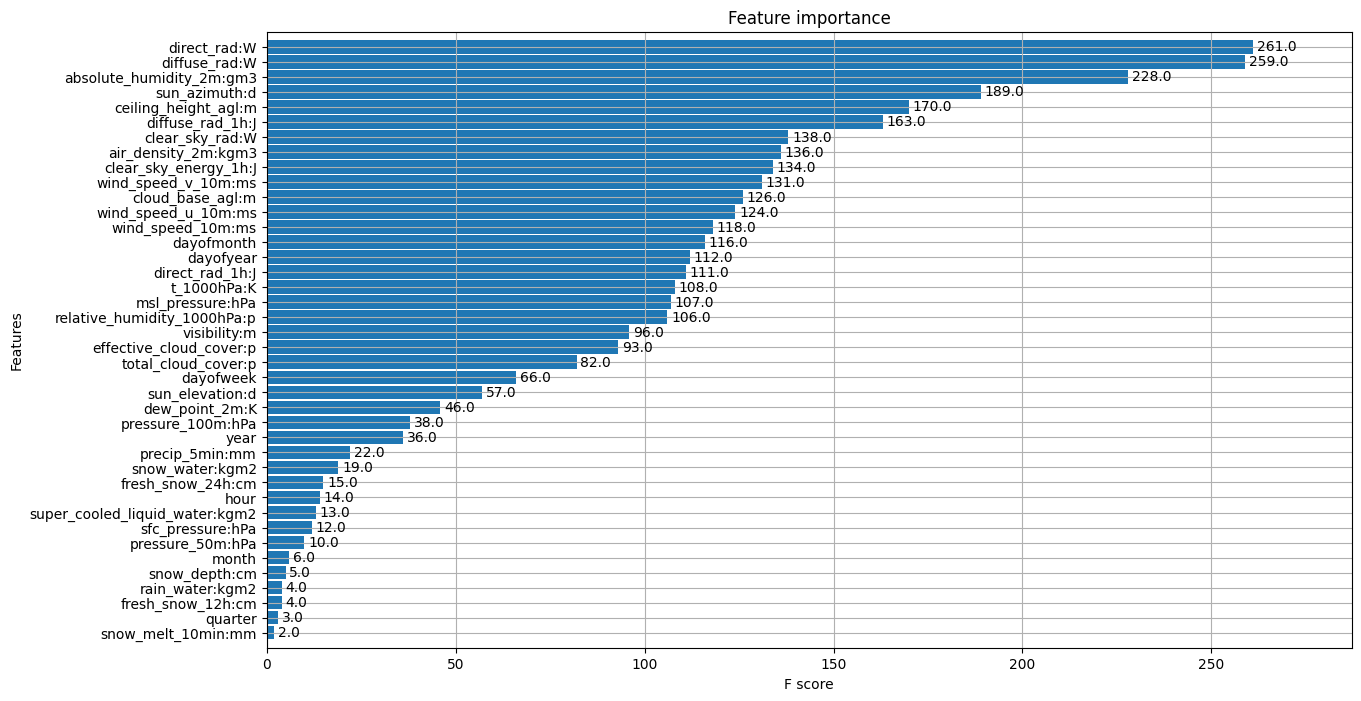

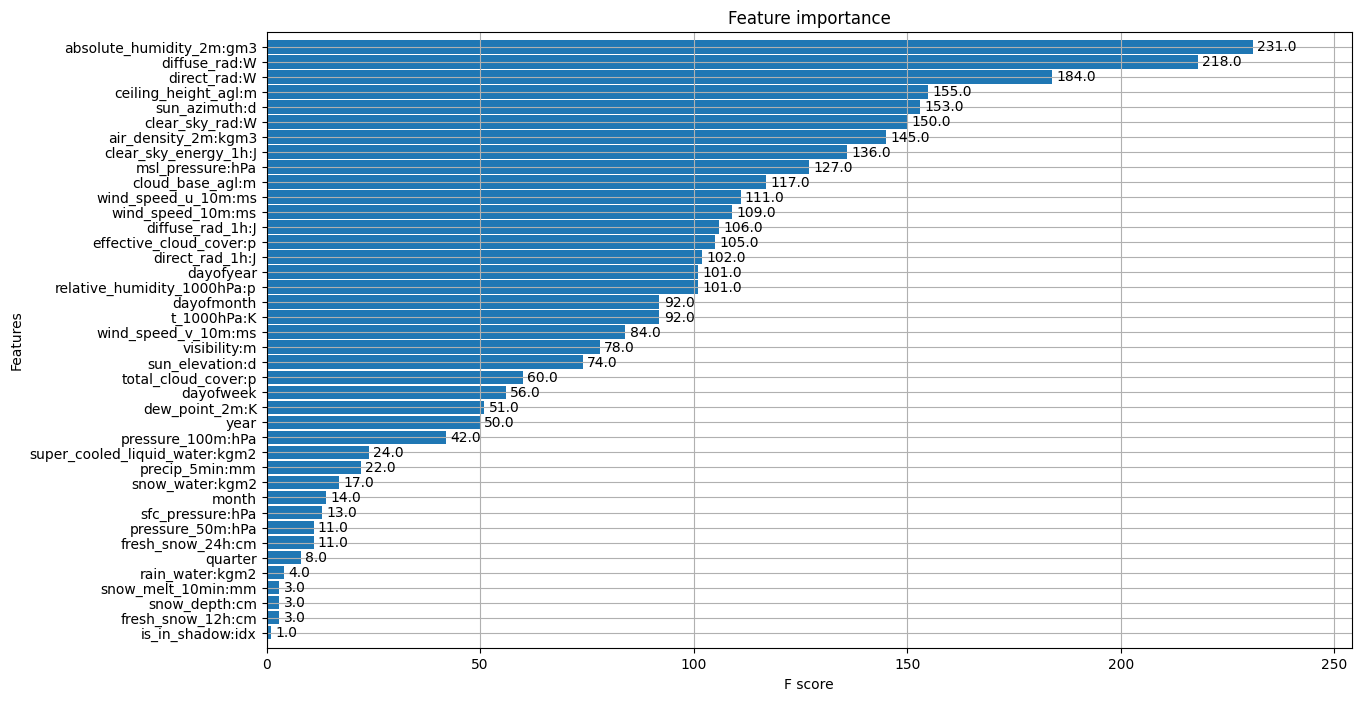

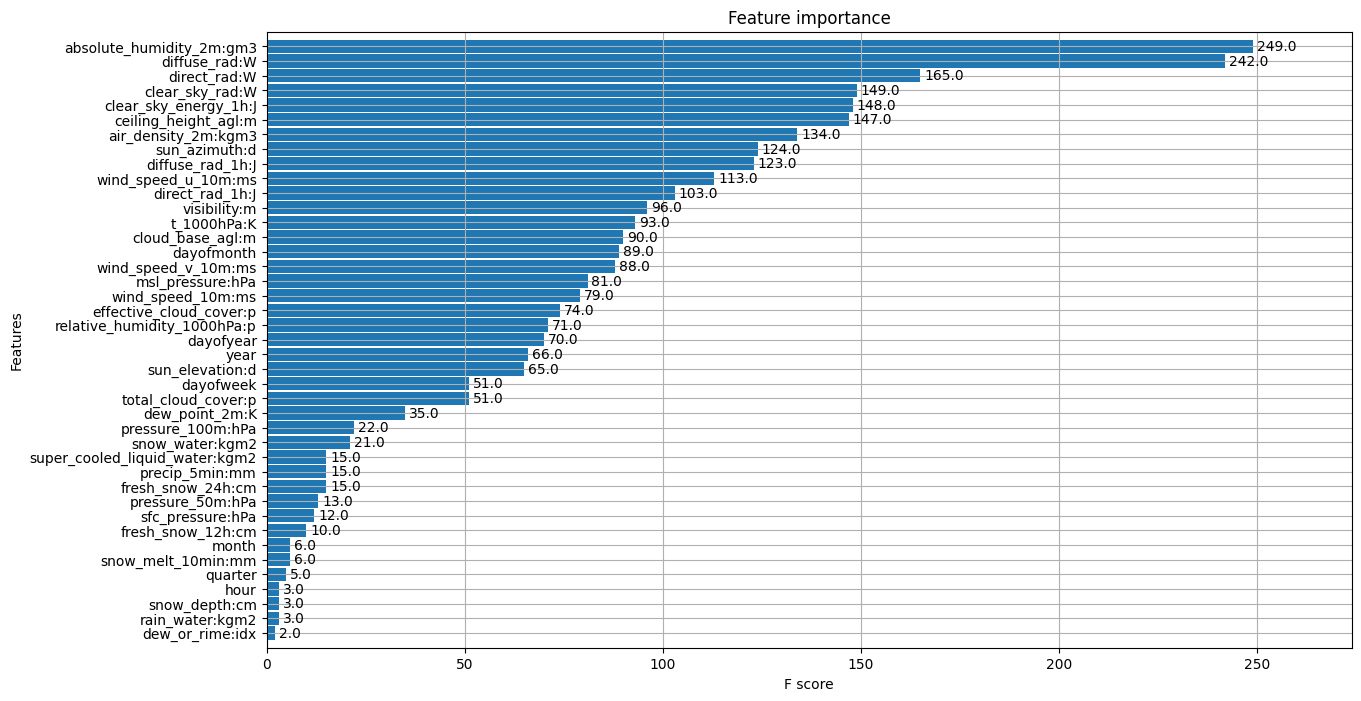

In [148]:
plot_importance(reg_a, height=.9)
plt.gcf().set_size_inches(14, 8)
plot_importance(reg_b, height=0.9)
plt.gcf().set_size_inches(14, 8)
plot_importance(reg_c, height=0.9)
plt.gcf().set_size_inches(14, 8)

In [149]:
pv_test_a['pv_measurement_prediction'] = reg_a.predict(X_test_a_norm)
pv_all_a = pd.concat([pv_test_a, pv_train_a], sort=False)

pv_test_b['pv_measurement_prediction'] = reg_b.predict(X_test_b_norm)
pv_all_b = pd.concat([pv_test_b, pv_train_b], sort=False)

pv_test_c['pv_measurement_prediction'] = reg_c.predict(X_test_c_norm)
pv_all_c = pd.concat([pv_test_c, pv_train_c], sort=False)

In [150]:
pv_all_c['pv_measurement']

11759     0.00
11760     0.00
11761     0.00
11762     9.80
11763    39.20
         ...  
21697    50.96
21698     2.94
21699     0.00
21700    -0.00
21701    -0.00
Name: pv_measurement, Length: 21702, dtype: float64

In [151]:
mae_a = np.mean(np.abs(pv_all_a['pv_measurement'] - pv_all_a['pv_measurement_prediction']))
mae_b = np.mean(np.abs(pv_all_b['pv_measurement'] - pv_all_b['pv_measurement_prediction']))
mae_c = np.mean(np.abs(pv_all_a['pv_measurement'] - pv_all_c['pv_measurement_prediction']))

mae = (mae_a + mae_b + mae_c) / 3
print("MAE a:", mae_a, "MAE b:", mae_b, "MAE c:", mae_c)
print("MAE on test set:", mae)

MAE a: 368.78940809100544 MAE b: 73.88493493490266 MAE c: 238.94376868648607
MAE on test set: 227.20603723746476


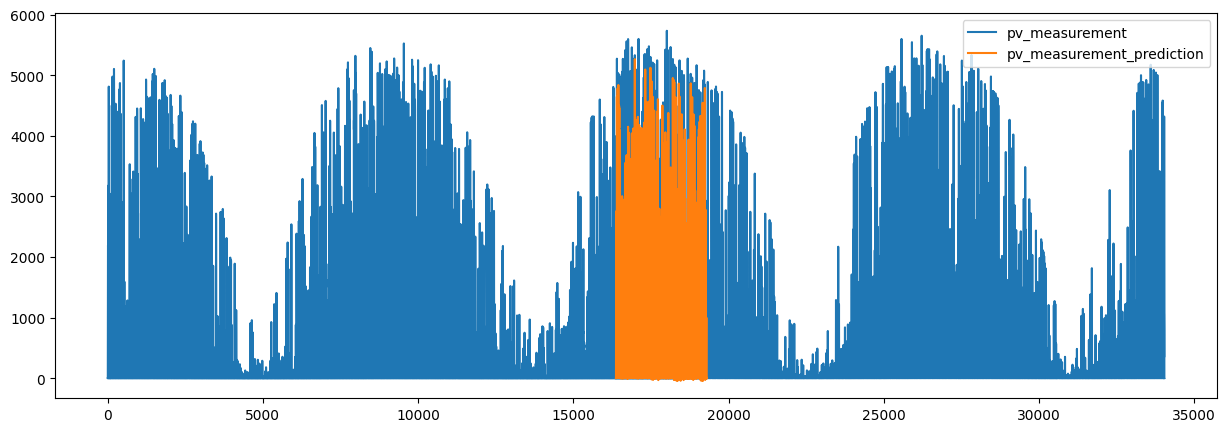

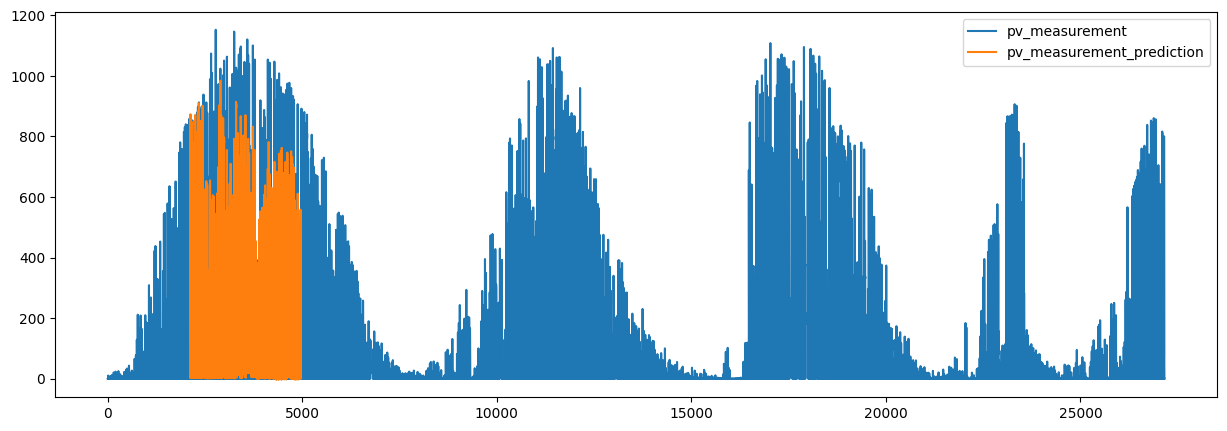

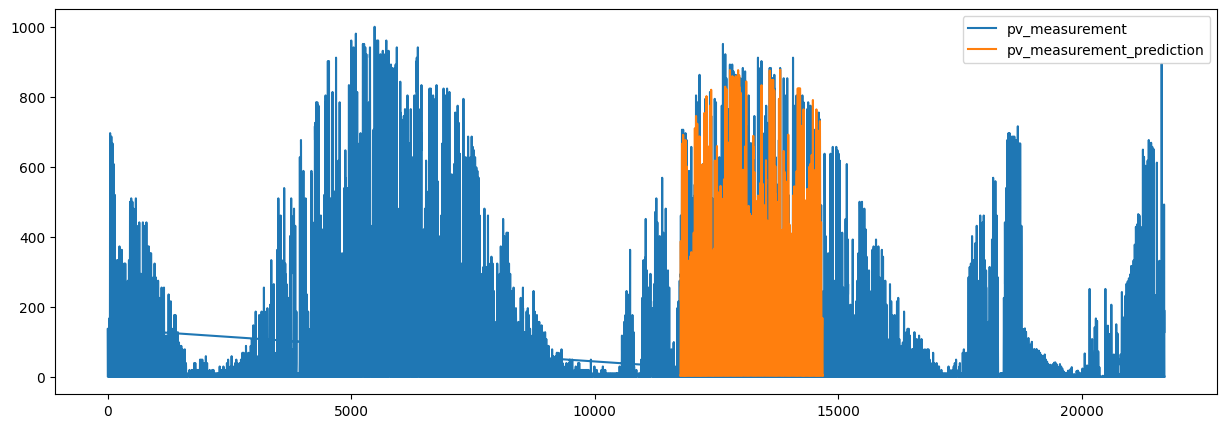

In [152]:
graph = pv_all_a[['pv_measurement','pv_measurement_prediction']].plot(figsize=(15, 5))
graph = pv_all_b[['pv_measurement','pv_measurement_prediction']].plot(figsize=(15, 5))
graph = pv_all_c[['pv_measurement','pv_measurement_prediction']].plot(figsize=(15, 5))

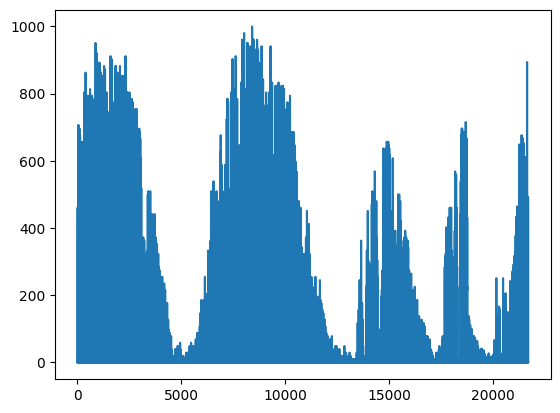

In [153]:
np_pv_c = np.array(pv_all_c['pv_measurement'])
plt.plot(np_pv_c)

# Export sur Kaggle

In [154]:
test = pd.read_csv(path+"test.csv")
test_copy = test.copy()
test.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
test["date_forecast"] = pd.to_datetime(test["date_forecast"]) #mettre le bon type

In [155]:
# Lecture des données météo associée :
merged_df_pre_a = pd.merge(X_test_estimated_a, test, on='date_forecast', how='inner')
merged_df_a = merged_df_pre_a[merged_df_pre_a["location"]=="A"]
merged_df_pre_b = pd.merge(X_test_estimated_b, test, on='date_forecast', how='inner')
merged_df_b = merged_df_pre_b[merged_df_pre_b["location"]=="B"]
merged_df_pre_c = pd.merge(X_test_estimated_c, test, on='date_forecast', how='inner')
merged_df_c = merged_df_pre_c[merged_df_pre_c["location"]=="C"]

In [156]:
def preprocessing_test(df,scaler):
  X_test = df.drop(["id","location","prediction"],axis=1)
  X_test = create_features(X_test, None)
  #X_test[('date_forecast')] = X_test[('date_forecast')].values.astype("float64")
  X_test = gestion_nan(X_test)
  X_test = sklearn_z_score_normalize_dataframe(X_test,return_scaler=False,scaler=scaler)
  return X_test

In [157]:
X_test_a_test = preprocessing_test(merged_df_a,scaler_a)
X_test_b_test = preprocessing_test(merged_df_b,scaler_b)
X_test_c_test = preprocessing_test(merged_df_c,scaler_c)

In [158]:
result_A = reg_a.predict(X_test_a_test)
result_B = reg_b.predict(X_test_b_test)
result_C = reg_c.predict(X_test_c_test)

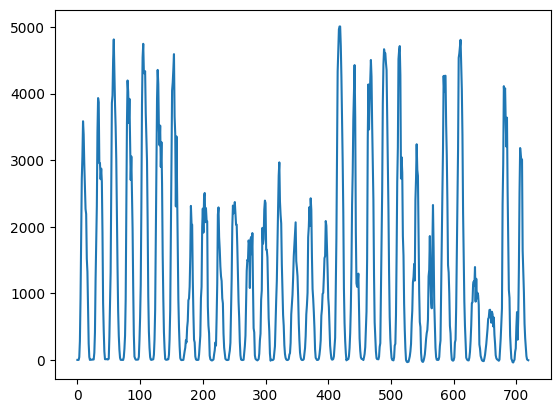

In [159]:
plt.plot(result_A)

In [160]:
nom_fichier = 'XGBoost_Valentin_V2'
repertoire = path
result = np.concatenate((np.concatenate((result_A,result_B)), result_C))
test_copy['prediction'] = result
sample_submission = sample_submission[['id']].merge(test_copy[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv(repertoire+ nom_fichier+'.csv', index=False)

Prochaines amélioration

- mettre un minimum *Done*
- suppression des zones continues en B et C *To DO*
- prise en compte de la date (jour/mois/heure) *Done* peut être ajusté ?
- prendre le meilleur model : celui avec le meilleur score sur le deuxième testset (A : 2,8% B : 5,5%  C: 11,5%) (score eval prévu : 166) --> déjà pris en copmte dans la fonction ...


Perf V1:

A : Test 2 : 446 / 459

B : Test 2 : 101 / 107

C : Test 2 : 68 / 78

Perf V2:

A : Test 1 : 243 | Test 2 : 438 / 455

B : Test 1 : 35 | Test 2 : 106 / 110

C : Test 1 : 26 | Test 2 : 65 / 71

# Post traitement

Ici, on va faire en sorte de n'avoir que des valeurs positives (cela ne représente qu'une légère amélioration

In [161]:
result = np.concatenate((np.concatenate((result_A,result_B)), result_C))

In [162]:
negative_values = result[result < 0]
sum_of_negatives = np.sum(negative_values**2)/len(result)
np.sqrt(sum_of_negatives)

2.0473158275656753

In [163]:
negative_mask = result < 0
result[negative_mask] = 0

In [164]:
nom_fichier = f'XGBoost_Arthur_split_dates_{split_date_a}_{split_date_b}_and_{split_date_c}'
repertoire = path
test_copy['prediction'] = result
sample_submission = sample_submission[['id']].merge(test_copy[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv(repertoire+ nom_fichier+'.csv', index=False)

In [165]:
result2 = np.concatenate((np.concatenate((result_A,result_B)), result_C))

In [166]:
negative_mask2 = result2 < 0
result2[negative_mask2] = 0

**Liste amélioration V2** :

- Gestion zones continues B et C (suppression)
-